<a href="https://colab.research.google.com/github/deepikajoon/road-accident-analysis/blob/main/rta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Techniques: DBSCAN (batch), Anomaly Detection (Z-score, IQR, IsolationForest), Ensembles (DecisionTree, Bagging, AdaBoost, RandomForest)

In [ ]:
#install & imports
!pip install -q pandas numpy matplotlib seaborn scikit-learn scipy

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, davies_bouldin_score
from scipy import stats

print("imports ready")


imports ready


In [ ]:
#load data
DATA_PATH = "/content/US_Accidents_Sample_100k.csv"
df = pd.read_csv(DATA_PATH)
print("loaded", DATA_PATH, "shape:", df.shape)
df.head()


loaded /content/US_Accidents_Sample_100k.csv shape: (100000, 76)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Traffic_Signal_Text,Duration_Category,Year,Month,Day,Hour,Weekday,DayOfWeek,Quarter,Is_Weekend
0,A-7182628,Source1,1,2020-04-17 09:29:30,2020-04-17 10:29:30,26.706900,-80.119360,26.7069,-80.11936,0.00,...,Yes,30-60 phút,2020,4,17,9,Friday,4,2,0
1,A-156000,Source3,3,2016-08-12 16:45:00,2016-08-12 17:15:00,33.985249,-84.269348,NaN,NaN,0.00,...,No,< 30 phút,2016,8,12,16,Friday,4,3,0
2,A-1871277,Source2,3,2019-09-20 15:22:16,2019-09-20 15:56:00,47.118706,-122.556908,NaN,NaN,0.00,...,No,30-60 phút,2019,9,20,15,Friday,4,3,0
3,A-2031222,Source2,2,2019-06-03 16:55:43,2019-06-03 18:12:09,33.451355,-111.890343,NaN,NaN,0.00,...,No,1-2 giờ,2019,6,3,16,Monday,0,2,0
4,A-1167415,Source2,2,2021-02-04 12:48:21,2021-02-04 16:51:15,42.448910,-93.721138,NaN,NaN,7.77,...,No,> 4 giờ,2021,2,4,12,Thursday,3,1,0


In [ ]:
#inspect required columns
cols = df.columns.tolist()
print("columns sample:", cols[:40])
required = ['Start_Lat','Start_Lng','Start_Time','Severity','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Weather_Condition']
for c in required:
    print(c, "in df?", c in df.columns)


columns sample: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming']
Start_Lat in df? True
Start_Lng in df? True
Start_Time in df? True
Severity in df? True
Temperature(F) in df? True
Humidity(%) in df? True
Pressure(in) in df? True
Visibility(mi) in df? True
Wind_Speed(mph) in df? True
Weather_Condition in df? True


In [ ]:
#select & create time features
keep = ['ID','Severity','Start_Time','Start_Lat','Start_Lng','Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Weather_Condition','Start_Hour','Start_Day','Start_Month']
keep = [c for c in keep if c in df.columns]
df = df[keep].copy()

if 'Start_Time' in df.columns:
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    if 'Start_Hour' not in df.columns:
        df['Start_Hour'] = df['Start_Time'].dt.hour
    if 'Start_Day' not in df.columns:
        df['Start_Day'] = df['Start_Time'].dt.day
    if 'Start_Month' not in df.columns:
        df['Start_Month'] = df['Start_Time'].dt.month

print("after select shape:", df.shape)
df.head()


after select shape: (100000, 15)


,ID,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Weather_Condition,Start_Hour,Start_Day,Start_Month
0,A-7182628,1,2020-04-17 09:29:30,26.706900,-80.119360,0.00,78.0,81.0,30.13,10.0,13.0,Cloudy,9.0,17.0,4.0
1,A-156000,3,2016-08-12 16:45:00,33.985249,-84.269348,0.00,91.0,47.0,29.91,10.0,10.4,Clear,16.0,12.0,8.0
2,A-1871277,3,2019-09-20 15:22:16,47.118706,-122.556908,0.00,67.0,84.0,29.78,10.0,3.0,Cloudy,15.0,20.0,9.0
3,A-2031222,2,2019-06-03 16:55:43,33.451355,-111.890343,0.00,95.0,16.0,28.53,10.0,6.0,Clear,16.0,3.0,6.0
4,A-1167415,2,2021-02-04 12:48:21,42.448910,-93.721138,7.77,19.0,93.0,28.41,0.5,28.0,Light Snow / Windy,12.0,4.0,2.0


In [ ]:
# basic imputation & encoding
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

if num_cols:
    df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
if cat_cols:
    df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])

if 'Weather_Condition' in df.columns:
    le = LabelEncoder()
    df['Weather_Condition_enc'] = le.fit_transform(df['Weather_Condition'].astype(str))


In [ ]:
#scale numeric for clustering and models
scale_cols = [c for c in ['Start_Lat','Start_Lng','Start_Hour','Visibility(mi)','Temperature(F)','Humidity(%)','Distance(mi)'] if c in df.columns]
scaler = StandardScaler()
if scale_cols:
    df[scale_cols] = scaler.fit_transform(df[scale_cols])
print("scaled cols:", scale_cols)


scaled cols: ['Start_Lat', 'Start_Lng', 'Start_Hour', 'Visibility(mi)', 'Temperature(F)', 'Humidity(%)', 'Distance(mi)']


In [ ]:

# DBSCAN batch clustering (replace KMeans)

# DBSCAN fit
X_db_cols = [c for c in ['Start_Lat','Start_Lng','Start_Hour','Visibility(mi)','Temperature(F)','Humidity(%)','Distance(mi)'] if c in df.columns]
X_db = df[X_db_cols].fillna(0).values

# tune eps/min_samples if needed
db = DBSCAN(eps=0.35, min_samples=50)
db_labels = db.fit_predict(X_db)
df['DBSCAN_cluster'] = db_labels
print("unique labels:", np.unique(db_labels)[:10], "noise count:", (db_labels==-1).sum())


unique labels: [-1  0  1  2  3  4  5  6  7  8] noise count: 73744


In [ ]:
#evaluate DBSCAN on non-noise points
mask = db_labels != -1
if mask.sum() > 1 and len(np.unique(db_labels[mask]))>1:
    try:
        s_db = silhouette_score(X_db[mask], db_labels[mask])
        dbi_db = davies_bouldin_score(X_db[mask], db_labels[mask])
    except Exception as e:
        s_db, dbi_db = np.nan, np.nan
else:
    s_db, dbi_db = np.nan, np.nan
print("DBSCAN silhouette:", s_db, "DB index:", dbi_db)


DBSCAN silhouette: 0.009243184969993311 DB index: 1.2477644321590875


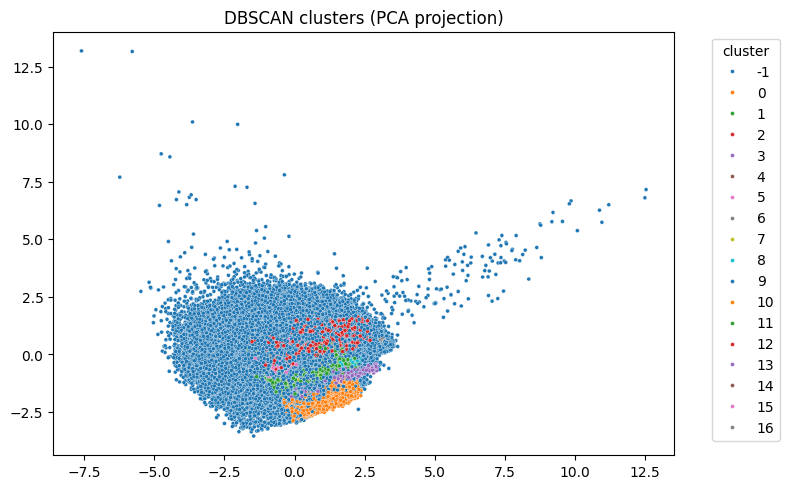

In [ ]:
# PCA plot of DBSCAN clusters
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_db)
plt.figure(figsize=(8,5))
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df['DBSCAN_cluster'], palette='tab10', s=8, legend='brief')
plt.title("DBSCAN clusters (PCA projection)")
plt.legend(title='cluster', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


In [ ]:

# Anomaly detection

#  Z-score & IQR
num_for_anom = [c for c in ['Visibility(mi)','Temperature(F)','Humidity(%)','Distance(mi)'] if c in df.columns]
if num_for_anom:
    z = np.abs(stats.zscore(df[num_for_anom].fillna(0)))
    df['z_outlier'] = (z > 3).any(axis=1).astype(int)
    Q1 = df[num_for_anom].quantile(0.25)
    Q3 = df[num_for_anom].quantile(0.75)
    IQR = Q3 - Q1
    df['iqr_outlier'] = ((df[num_for_anom] < (Q1 - 1.5*IQR)) | (df[num_for_anom] > (Q3 + 1.5*IQR))).any(axis=1).astype(int)
    print("z_outliers:", df['z_outlier'].sum(), "iqr_outliers:", df['iqr_outlier'].sum())
else:
    df['z_outlier'] = 0
    df['iqr_outlier'] = 0


z_outliers: 4769 iqr_outliers: 30302


In [ ]:
# Isolation Forest
iso_feats = [c for c in ['Start_Lat','Start_Lng','Start_Hour','Visibility(mi)','Temperature(F)','Distance(mi)'] if c in df.columns]
if iso_feats:
    iso = IsolationForest(contamination=0.02, random_state=42)
    df['iso_label'] = iso.fit_predict(df[iso_feats].fillna(0))
    df['iso_outlier'] = (df['iso_label'] == -1).astype(int)
    print("iso outliers:", df['iso_outlier'].sum())
else:
    df['iso_outlier'] = 0


iso outliers: 2000


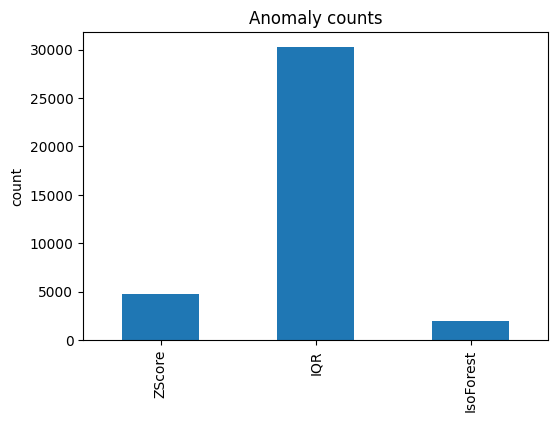

In [ ]:
#anomaly comparison plot
anom_counts = pd.Series({
    'ZScore': int(df['z_outlier'].sum()),
    'IQR': int(df['iqr_outlier'].sum()),
    'IsoForest': int(df['iso_outlier'].sum())
})
anom_counts.plot(kind='bar', title='Anomaly counts', figsize=(6,4))
plt.ylabel('count')
plt.show()


In [ ]:

# Ensemble classification

# prepare classification data
clf_features = [c for c in ['Start_Lat','Start_Lng','Start_Hour','Visibility(mi)','Temperature(F)','Humidity(%)','Distance(mi)','Weather_Condition_enc'] if c in df.columns]
X = df[clf_features].fillna(0).values
y = df['Severity'].astype(int).values

# if many severity classes and extreme imbalance, you can optionally map to fewer classes; here keep as-is
unique_y = np.unique(y)
print("unique severity classes:", unique_y)


unique severity classes: [1 2 3 4]


In [ ]:
#  train test split
if len(unique_y) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("train/test:", X_train.shape, X_test.shape)


train/test: (75000, 8) (25000, 8)


In [ ]:
#Decision Tree baseline
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_dt)
print("DecisionTree acc:", round(acc_dt,4))
print(classification_report(y_test, y_dt))


DecisionTree acc: 0.7801
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       234
           2       0.78      0.99      0.88     19428
           3       0.56      0.06      0.10      4665
           4       0.00      0.00      0.00       673

    accuracy                           0.78     25000
   macro avg       0.34      0.26      0.24     25000
weighted avg       0.71      0.78      0.70     25000



In [ ]:
#  Bagging experiments
bag_scores = {}
for n in [3,5,7,9]:
    bag = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=n, random_state=42)
    bag.fit(X_train, y_train)
    yb = bag.predict(X_test)
    bag_scores[n] = accuracy_score(y_test, yb)
    print("Bagging", n, "acc:", round(bag_scores[n],4))


Bagging 3 acc: 0.7656
Bagging 5 acc: 0.7868
Bagging 7 acc: 0.794
Bagging 9 acc: 0.7969


In [ ]:
# AdaBoost experiments
ada_scores = {}
for n in [3,5,7,9]:
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=n, random_state=42)
    ada.fit(X_train, y_train)
    ya = ada.predict(X_test)
    ada_scores[n] = accuracy_score(y_test, ya)
    print("AdaBoost", n, "acc:", round(ada_scores[n],4))


AdaBoost 3 acc: 0.7771
AdaBoost 5 acc: 0.7698
AdaBoost 7 acc: 0.7771
AdaBoost 9 acc: 0.7771


In [ ]:
#Random Forest final
rf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_rf)
print("RandomForest acc:", round(acc_rf,4))
print(classification_report(y_test, y_rf))


RandomForest acc: 0.8036
              precision    recall  f1-score   support

           1       0.33      0.01      0.02       234
           2       0.82      0.96      0.88     19428
           3       0.65      0.29      0.40      4665
           4       0.50      0.00      0.01       673

    accuracy                           0.80     25000
   macro avg       0.58      0.32      0.33     25000
weighted avg       0.77      0.80      0.76     25000



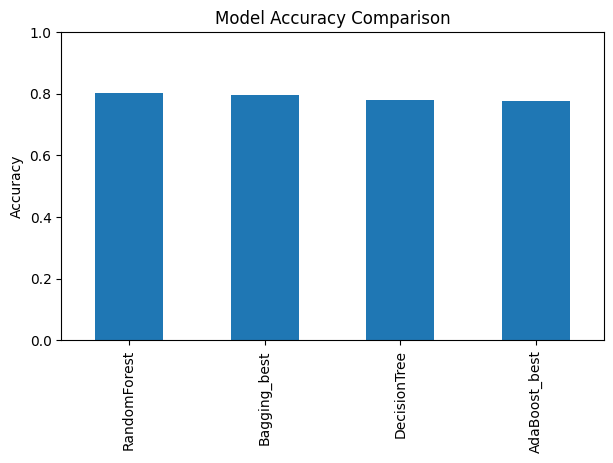

,accuracy
RandomForest,0.80356
Bagging_best,0.79692
DecisionTree,0.78012
AdaBoost_best,0.77712


In [ ]:
#model comparison plot
model_scores = {
    'DecisionTree': acc_dt,
    'RandomForest': acc_rf,
    'Bagging_best': max(bag_scores.values()) if bag_scores else np.nan,
    'AdaBoost_best': max(ada_scores.values()) if ada_scores else np.nan
}
model_df = pd.Series(model_scores).dropna().sort_values(ascending=False).to_frame('accuracy')
model_df.plot(kind='bar', legend=False, figsize=(7,4))
plt.ylim(0,1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()
model_df


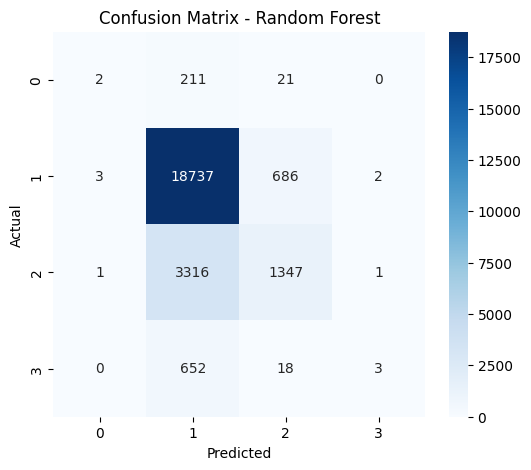

In [ ]:
#confusion matrix for Random Forest
cm = confusion_matrix(y_test, y_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
#Save outputs
out_path = "/content/traffic_accidents_analysis_results.csv"
df.to_csv(out_path, index=False)
print("Saved results to", out_path)


Saved results to /content/traffic_accidents_analysis_results.csv
